# Faces2mp4: Faces to movie

*A photographical timelapse project*

This Jupyter notebook is for turning a series of selfies into a movie, by automatically finding-cropping and assembling each image provided. The time between each image is proportional of the time that passed between each picture, keeping the same rate.

This kind of utility most likely exists, but I wanted to build my own version that I could tune to my desire.

This script uses all the `.jpg` images in the current directory, having a known filename that containes date and time information.

## Get the source files

Let's start by getting and filtering all the images based on their extension:

In [1]:
import os

files = [file.name for file in os.scandir(".")
         if os.path.splitext(file)[1].upper() == ".JPG"
         ]
files.sort()

# Perform the face detection

Let's have a batch opening and processing of the images, detecting all the faces one after the other. In case multiple faces are found for the first image, it uses the biggest face found. For the subsequent images, it is relying on the face that has the closest size to the one found in the first image.

Faces found in 20200314_210412.jpg : 1
Faces found in 20200315_210129.jpg : 1
Faces found in 20200316_222203.jpg : 1
Faces found in 20200317_210038.jpg : 1
Faces found in 20200318_210044.jpg : 1
Faces found in 20200319_210119.jpg : 1
Faces found in 20200320_210107.jpg : 1
Faces found in 20200321_210119.jpg : 1
Faces found in 20200322_210755.jpg : 1
Faces found in 20200323_210137.jpg : 1
Faces found in 20200324_210026.jpg : 1
Faces found in 20200325_214120.jpg : 1
Faces found in 20200326_210311.jpg : 1
Faces found in 20200327_210442.jpg : 1
Faces found in 20200328_210037.jpg : 1
Faces found in 20200329_211307.jpg : 1
Faces found in 20200330_210115.jpg : 1
Faces found in 20200331_210135.jpg : 1
Faces found in 20200401_210108.jpg : 1
Faces found in 20200402_211617.jpg : 1
Faces found in 20200403_210127.jpg : 1
Faces found in 20200404_210056.jpg : 1
Faces found in 20200405_210202.jpg : 1
Faces found in 20200406_215640.jpg : 1
Faces found in 20200407_211043.jpg : 1
Faces found in 20200408_2

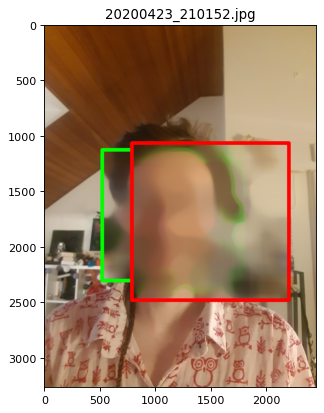

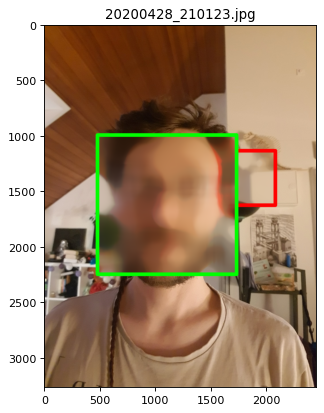

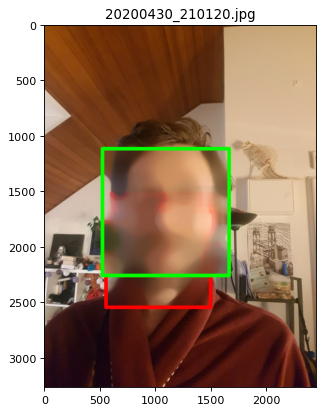

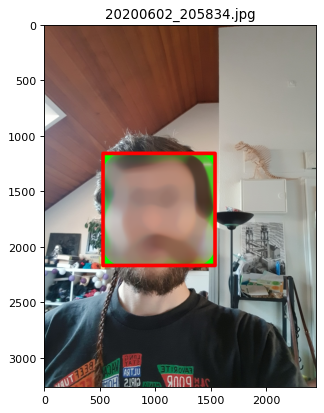

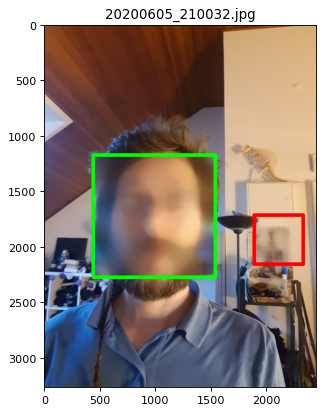

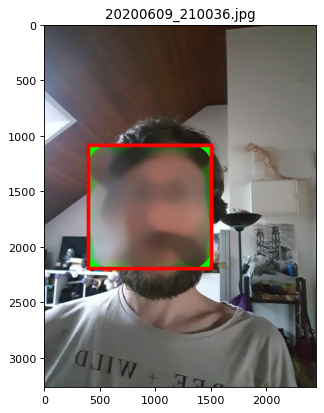

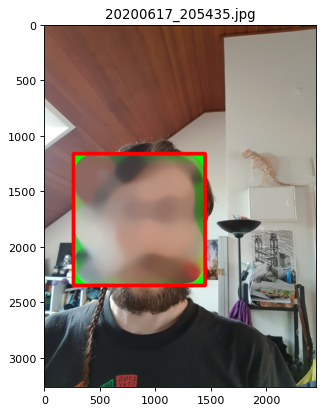

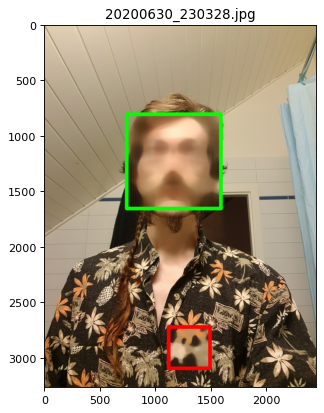

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Helper function


def convertToRGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Load the face detection classifier (source: https://github.com/opencv/opencv/tree/master/data/)
haar_cascade_face = cv2.CascadeClassifier(
    'haarcascade_frontalface_default.xml')

faces = []
img_shapes = []
first_surface = 0
for img in files:
    # Open source data
    img_raw = cv2.imread(img)
    img_shapes.append(img_raw.shape)

    # The face detection itself
    minSizeFace = int(img_raw.shape[0]/10)  # minimum size of a face
    faces_detected = haar_cascade_face.detectMultiScale(
        img_raw, minSize=(minSizeFace, minSizeFace))
    print('Faces found in {} : {}'.format(img, len(faces_detected)))

    # Compute the surface of the biggest face detected in the first image
    # (it will be used later when multiple faces are detected, to select the closest match)
    if first_surface == 0:
        first_surface = max([w*h for (x, y, w, h) in faces_detected])

    # We want not more than a face, and not fewer than a face. Let's find the best one
    best = 0  # which face in the detection array is the best

    if len(faces_detected) == 0:
        # Create two faces detected from the previous image as an approximation raising a warning
        # This assumes at least a face has been detected in the first image
        faces_detected = []
        faces_detected.append(faces[-1])
        faces_detected.append(faces[-1])

    if len(faces_detected) > 1:
        # We have detected multiple faces, select the one closest in size to the one in the first image
        plt.figure(num=None, figsize=(26, 6), dpi=80)
        # Face highlight thickness depends on the image size
        thickness = int(max(img_raw.shape)/100)

        # Compute the face's surface difference from first image, to find the best one
        surface_diffs = [abs(w*h - first_surface)
                         for (x, y, w, h) in faces_detected]
        best = surface_diffs.index(min(surface_diffs))

        for j, faces_rect in enumerate(faces_detected):
            (x, y, w, h) = faces_rect  # unpack face rectangle properties

            # Blur the face because of the Internetz
            sub_face = img_raw[y:y+h, x:x+w]
            sub_face = cv2.medianBlur(sub_face, int(w/6/2)*2 + 1)
            img_raw[y:y+sub_face.shape[0], x:x+sub_face.shape[1]] = sub_face

            cv2.rectangle(img_raw, (x, y), (x+w, y+h),
                          (0, 255*(j == best), 255*(j != best)), thickness)

        plt.imshow(convertToRGB(img_raw))
        plt.title(img)

    faces.append(faces_detected[best])

Now we have the face data, let's have a rough preview of what we have for the first few images:

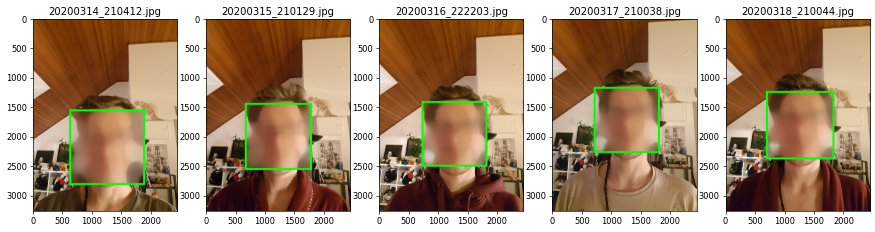

In [3]:
plt.figure(num=None, figsize=(18, 6), dpi=60)
for i, (img, faces_rect, shape) in enumerate(zip(files, faces, img_shapes), 1):
    # Preview for the first 5 images
    if i > 5:
        continue

    img_raw = cv2.imread(img)

    # Prepare the display
    plt.subplot(1, 5, i)
    plt.title(img)

    # Get/compute parameters
    # Face highlight thickness depends on the image size
    thickness = int(max(img_raw.shape)/100)
    (x, y, w, h) = faces_rect  # unpack face rectangle properties

    # Blur the face because of the Internetz
    sub_face = img_raw[y:y+h, x:x+w]
    sub_face = cv2.medianBlur(sub_face, int(w/4/2)*2 + 1)
    img_raw[y:y+sub_face.shape[0], x:x+sub_face.shape[1]] = sub_face

    # Highlight the face
    cv2.rectangle(img_raw, (x, y), (x+w, y+h), (0, 255, 0), thickness)

    plt.imshow(convertToRGB(img_raw))

# Scale, crop, and save the images

Now, we can scale and crop all the images around the face, giving little margins everywhere. The face is modeled from the average detected aspect-ratio.

In [4]:
ratio = 0.
for face_rect in faces:
    (x, y, w, h) = face_rect
    ratio += float(w)/float(h)

ratio /= len(faces)

assert int(ratio * 100) == 100

It looks like the classifier returns not any kind of rectangle, but exactly a square (with at least two decimals). Or my face is super square, which is also possible, but I wouldn't have guessed. Let's scale all the images so that all faces have the same size, canceling (some) problems of being closer or further than the camera.

In [5]:
import math

smallest = math.inf

for x, y, w, h in faces:
    smallest = min(smallest, w)

scalings = []
scaled_shapes = []
scaled_faces = []
for (H, W, _), (x, y, w, h) in zip(img_shapes, faces):
    s = smallest/w
    s /= 1.3  # My images are big, I can scale them further
    scalings.append(s)

    scaled_shapes.append((int(s*H), int(s*W)))
    scaled_faces.append((int(x*s), int(y*s), int(w*s), int(h*s)))

Let's get what can be the biggest margins for our images

In [6]:
from functools import reduce

margins = {}
for (H, W), (x, y, w, h) in zip(scaled_shapes, scaled_faces):
    margins['top'] = int(math.floor(min(margins.get('top', math.inf), y)))
    margins['left'] = int(math.floor(min(margins.get('left', math.inf), x)))
    margins['bottom'] = int(math.floor(
        min(margins.get('bottom', math.inf), H-(y+h))))
    margins['right'] = int(math.floor(
        min(margins.get('right', math.inf), W-(x+w))))
print("Margins:", margins)

Margins: {'top': 250, 'left': 129, 'bottom': 137, 'right': 218}


Now, we can resize and crop all the images to the same canvas.

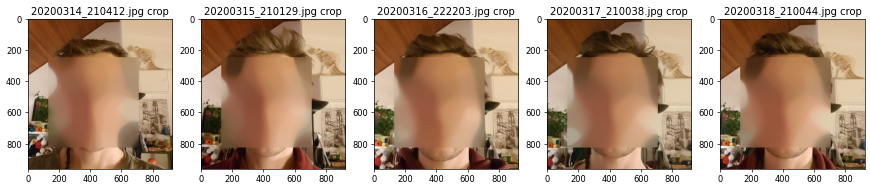

In [7]:
plt.figure(num=None, figsize=(18, 6), dpi=60)
imgs = []
cropped_faces = []
for i, (path, (x, y, w, h), s) in enumerate(zip(files, scaled_faces, scalings), 1):
    img = cv2.imread(path)

    # Resize image
    img = cv2.resize(img, (0, 0), fx=s, fy=s)

    # Crop image, being encoder friendly with cropping being multiple of 2
    if (margins["top"]+h+margins["bottom"]) % 2 != 0:
        margins["top"] = margins["top"] - 1
    if (margins["left"]+w+margins["right"]) % 2 != 0:
        margins["right"] = margins["right"] - 1
    crop_img = img[y-margins["top"]:y+h+margins["bottom"],
                   x-margins["left"]:x+w+margins["right"]]
    crop_face = (margins["left"], margins["top"], w, h)

    # Save face position in the cropped images
    cropped_faces.append(crop_face)
    imgs.append(crop_img.copy())

    # Blur face for online publication
    (x, y, w, h) = crop_face
    sub_face = crop_img[y:y+h, x:x+w]
    sub_face = cv2.medianBlur(sub_face, int(w/4/2)*2 + 1)
    crop_img[y:y+sub_face.shape[0], x:x+sub_face.shape[1]] = sub_face

    # Save image (disabled as we'll export the morphing images)
    # cv2.imwrite('image_{}.png'.format(i),crop_img)

    # Preview for the first 5 images
    if i > 5:
        continue

    # Blur the face because of the Internetz
    (x, y, w, h) = crop_face
    sub_face = crop_img[y:y+h, x:x+w]
    sub_face = cv2.medianBlur(sub_face, int(w/4/2)*2 + 1)
    crop_img[y:y+sub_face.shape[0], x:x+sub_face.shape[1]] = sub_face

    plt.subplot(1, 5, i)
    plt.title(" ".join([path, "crop"]))
    plt.imshow(convertToRGB(crop_img))

# Time information

As an added bonus, it would be better to take into account the photo capture time when assembling the video. We therefore first need to parse the date-time from the image filenames, and I will normalize it between 0 and 1.

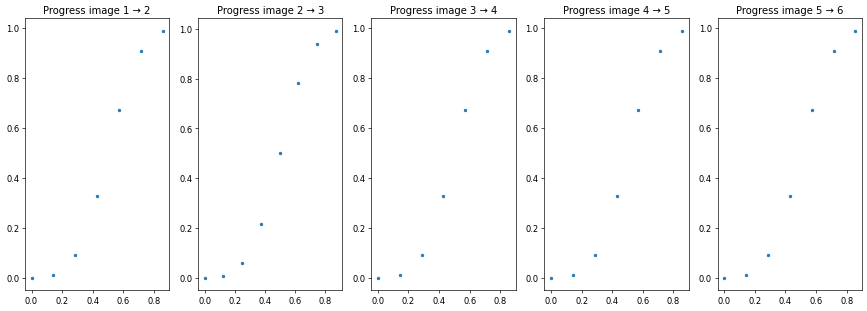

In [8]:
from datetime import datetime

plt.figure(num=None, figsize=(18, 6), dpi=60)

total_time = 30  # seconds of the video
fps = 25

# Parse
date_times = [datetime.strptime(file, '%Y%m%d_%H%M%S.jpg') for file in files]

# Zero-offset
date_times = [dt - date_times[0] for dt in date_times]

# Normalize from 0 to 1
date_times = [dt/date_times[-1] for dt in date_times]

# Stretch to `total_time` seconds seconds
date_times = [dt*total_time for dt in date_times]

# For each interval, for each frame, get the progression
progressions = []
for i, (t1, t2) in enumerate(zip(date_times[0:-1], date_times[1:]), 1):
    delta = t2-t1
    num_img = math.ceil(delta*fps)
    progress = np.linspace(0, 1, num_img, endpoint=False)

    # Ease in and out
    power = 2.5  # Defines how sharp the transition is
    progress_ease = progress**power / (progress**power + (1 - progress)**power)

    progressions.append(progress_ease)

    if i > 5:
        continue

    plt.subplot(1, 5, i)
    plt.plot(progress, progress_ease, '.')
    plt.title("Progress image {} → {}".format(i, i+1))

# Face landmarks for morphing interpolation

Yep, this title is full of keywords. Except it's maybe missing "deep learning", but it's because there is none here. I'm just using off-the-shelf tools and pre-trained models.

## Landmark identification

We first get the specific points of the face:

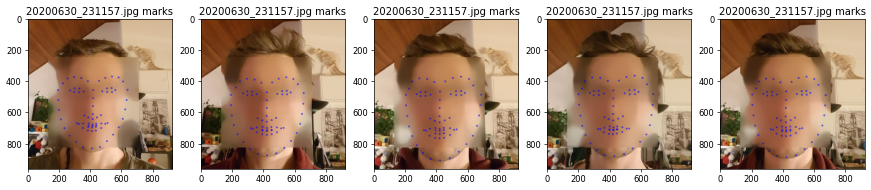

In [9]:
import numpy

plt.figure(num=None, figsize=(18, 6), dpi=60)

facemark = cv2.face.createFacemarkLBF()
# https://github.com/kurnianggoro/GSOC2017/blob/master/data/lbfmodel.yaml
facemark.loadModel("lbfmodel.yaml")

mark_points = []
for i, (img, face) in enumerate(zip(imgs, cropped_faces), 1):
    ok, landmarks = facemark.fit(img, numpy.array([face]))

    # Get all the points out of their structure
    points = []
    for mark in landmarks:
        for sub in mark:
            for point in sub:
                points.append(point)
    mark_points.append(points)

    # Preview for the first 5 images
    img = img.copy()
    if i > 5:
        continue

    # Blur the face because of the Internetz
    (x, y, w, h) = face
    sub_face = img[y:y+h, x:x+w]
    sub_face = cv2.medianBlur(sub_face, int(w/4/2)*2 + 1)
    img[y:y+sub_face.shape[0], x:x+sub_face.shape[1]] = sub_face

    for (x1, y1) in points:
        r = int(img.shape[0]/200)
        cv2.circle(img, center=(int(x1), int(y1)), radius=r,
                   color=(255, 0, 0), thickness=int(r/2))

    plt.subplot(1, 5, i)
    plt.title(" ".join([path, "marks"]))

    plt.imshow(convertToRGB(img))

## Triangulation

We can create now a map of triangles with the Delaunay algorithm. We will create a few additional points of the border of the image to bind the morphing to the sides.

In [10]:
subdivs = []
triangles = []
for img, mark in zip(imgs, mark_points):
    # Create points on the border
    for i in range(3):
        for j in range(3):
            if i == 1 and j == 1:
                continue
            point = (float(i)*(img.shape[1]-1)/2, float(j)*(img.shape[0]-1)/2)
            mark.append(point)

    # Rectangle to be used with Subdiv2D
    size = img.shape
    rect = (0, 0, size[1], size[0])
    subdiv = cv2.Subdiv2D(rect)

    for (x, y) in mark:
        # We can't add points as floats, need to be ints
        subdiv.insert((int(x), int(y)))

    subdivs.append(subdiv)
    triangles.append(subdiv.getTriangleList())

Let's have a view over the delightful triangulation:

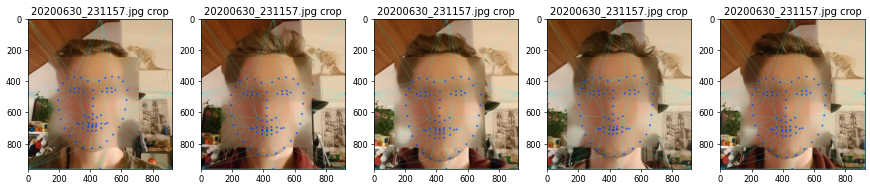

In [11]:
plt.figure(num=None, figsize=(18, 6), dpi=60)
for i, (img, points, subdiv, tris) in enumerate(zip(imgs, mark_points, subdivs, triangles), 1):
    # Preview for the first 5 images
    img = img.copy()
    if i > 5:
        continue

    # Blur the face because of the Internetz
    (x, y, w, h) = face
    sub_face = img[y:y+h, x:x+w]
    sub_face = cv2.medianBlur(sub_face, int(w/4/2)*2 + 1)
    img[y:y+sub_face.shape[0], x:x+sub_face.shape[1]] = sub_face

    # Draw Delaunay triangulation
    size = img.shape
    r = (0, 0, size[1], size[0])
    color = (255, 255, 0)

    for t in tris:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
        cv2.line(img, pt1, pt2, color)
        cv2.line(img, pt2, pt3, color)
        cv2.line(img, pt3, pt1, color)

    for (x1, y1) in points:
        r = int(img.shape[0]/200)
        cv2.circle(img, center=(int(x1), int(y1)), radius=r,
                   color=(255, 0, 0), thickness=int(r/2))

    plt.subplot(1, 5, i)
    plt.title(" ".join([path, "crop"]))

    plt.imshow(convertToRGB(img))

# Morphing

Code courtesy from [LearnOpenCV](https://github.com/spmallick/learnopencv/blob/master/FaceMorph/faceMorph.py), with many tweaks to get it to work with what I have. We start with some definitions, then actually using the functions.

In [12]:
# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size):

    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform(np.float32(srcTri), np.float32(dstTri))

    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine(src, warpMat, (size[0], size[1]), None,
                         flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    return dst


# Warps and alpha blends triangular regions from img1 and img2 to img
def morphTriangle(img1, img2, img, t1, t2, t, alpha):

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))
    r = cv2.boundingRect(np.float32([t]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = []
    t2Rect = []
    tRect = []

    for i in range(0, 3):
        tRect.append(((t[i][0] - r[0]), (t[i][1] - r[1])))
        t1Rect.append(((t1[i][0] - r1[0]), (t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))

    # Get mask by filling triangle
    mask = np.zeros((r[3], r[2], 3), dtype=np.float32)
    cv2.fillConvexPoly(mask, np.int32(tRect), (1.0, 1.0, 1.0), 16, 0)

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    img2Rect = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]

    size = (r[2], r[3])
    warpImage1 = applyAffineTransform(img1Rect, t1Rect, tRect, size)
    warpImage2 = applyAffineTransform(img2Rect, t2Rect, tRect, size)

    # Alpha blend rectangular patches
    imgRect = (1.0 - alpha) * warpImage1 + alpha * warpImage2

    # Copy triangular region of the rectangular patch to the output image
    img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = img[r[1]:r[1] + r[3],
                                              r[0]:r[0]+r[2]] * (1 - mask) + imgRect * mask

We can now use the defined functions to perform the morphing.

In [13]:
current_image = 0
for (img1, points1, subdiv1, tris1, img2, points2, subdiv2, tris2, alphas, face) in zip(imgs[0:-1], mark_points[0:-1], subdivs[0:-1], triangles[0:-1], imgs[1:], mark_points[1:], subdivs[1:], triangles[1:], progressions, cropped_faces):
    for alpha in alphas:
        # Allocate space for final output
        points = []
        imgMorph = alpha * img1 + (1-alpha) * img2

        # Compute the intermediate points position
        for i in range(0, len(points1)):
            x = (1 - alpha)*points1[i][0] + alpha*points2[i][0]
            y = (1 - alpha)*points1[i][1] + alpha*points2[i][1]
            points.append((x, y))

        # Create the triangles from the list of points (to be sure we have the same ordering)
        triangle_ids = []
        for t1 in tris1:
            distances = np.apply_along_axis(np.linalg.norm, 1,
                                            np.round(abs(np.subtract(points1, np.array([t1[0], t1[1]])))))
            i1 = np.where(distances == np.amin(distances))[0][0]
            distances = np.apply_along_axis(np.linalg.norm, 1,
                                            np.round(abs(np.subtract(points1, np.array([t1[2], t1[3]])))))
            i2 = np.where(distances == np.amin(distances))[0][0]
            distances = np.apply_along_axis(np.linalg.norm, 1,
                                            np.round(abs(np.subtract(points1, np.array([t1[4], t1[5]])))))
            i3 = np.where(distances == np.amin(distances))[0][0]
            triangle_ids.append([i1, i2, i3])

        t1 = []
        t2 = []
        t = []
        for (a, b, c) in triangle_ids:
            x = int(a)
            y = int(b)
            z = int(c)

            t1 = [points1[x], points1[y], points1[z]]
            t2 = [points2[x], points2[y], points2[z]]
            t = [points[x], points[y], points[z]]

            # Morph one triangle at a time.
            morphTriangle(img1, img2, imgMorph, t1, t2, t, alpha)

        # Blur the face because of the Internetz
        #(x,y,w,h) = face
        #sub_face = imgMorph[y:y+h, x:x+w]
        #sub_face = cv2.medianBlur(sub_face, int(w/4/2)*2 + 1)
        #imgMorph[y:y+sub_face.shape[0], x:x+sub_face.shape[1]] = sub_face

        # Save images
        cv2.imwrite('image_morph_{}.png'.format(current_image), imgMorph)
        current_image += 1

# Merging to a video

We now have a ton of `.png` images, let's turn that into a video. Even though there is a [`ffmpeg`](https://ffmpeg.org/) [python wrapper](https://github.com/kkroening/ffmpeg-python), I do not think it is pretty useful for such a simple usage:

```console
ffmpeg -r 25 -f image2 -i image_morph_%d.png -vcodec libx264 -preset veryslow -crf 21 -profile:v baseline -level 3.0 -pix_fmt yuv420p beard_morph.mp4
```

This command sets all the right options of a well compressed and widely compatible file that can be played on most smartphones.